# Análise de Fake News
Pergunta de negócio:
* Existem padrões notícias brasileiras que nos permitem suspeitar de fake news?

Na base de dados __FakeBR Corpus__, extraída de  https://sites.google.com/icmc.usp.br/opinando/, existem duas pastas que separam conjuntos distintos de notícias:
* `fake`: com notícias sabidamente falsas;
* `true`: com notícias sabidamente verdadeiras.

* As  notícias são de janeiro de 2016 a janeiro de 2018.
* São 3,6 mil nótiicas falsas e 3,6 verdadeiras.

# Bibliotecas


In [20]:
import nltk
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Paths

In [21]:
path="../data/fakenews/full_texts"
pT=path+"/true/*.txt"
pF=path+"/fake/*.txt"

# Spark

In [22]:
from pyspark.sql import SparkSession

In [23]:
spark = SparkSession.builder \
        .master('local[8]') \
        .appName('Exercicio True/Fale') \
        .getOrCreate()

In [24]:
sc = spark.sparkContext

In [25]:
fake = sc.wholeTextFiles(pF)
true=sc.wholeTextFiles(pT)

In [26]:
fake2 = fake.map(lambda x: x[1].lower())
true2 = true.map(lambda x: x[1].lower())

In [27]:
def punct0(x):
    
    punctuations = '''!-()[]{};:'"\,<>./"?!'''
    no_punct = ""
    for char in x:
        if char not in punctuations:
            no_punct = no_punct + char
    no_punct=no_punct.split()
    return(no_punct)

re=["segundafeira","terçafeira","quartafeira","quintafeira","sextafeira","sabádo","domingo","sete","dois","após"]
remo_port = nltk.corpus.stopwords.words('portuguese')+re


def remo_words(data,remo):
    a=[x for x in data if x not in remo]
    return(a)


In [28]:
fake3 = fake2.map(lambda x: punct0(x))
true3 = true2.map(lambda x: punct0(x))

In [29]:
fake4 = fake3.map(lambda x: remo_words(x,remo_port))
true4 = true3.map(lambda x: remo_words(x,remo_port))

In [30]:
def sum_words(x):
    x=x.split()
    w=np.unique(x)
    w=list(map(lambda i: str(i),w))
    a=list(map(lambda i: x.count(i),w))
    r=list(zip(w,a))
    return(r)


In [31]:
fake_words=fake4.map(lambda x: sum_words(x[0]))
fake_words=fake_words.map(lambda x: x[0])
true_words=true4.map(lambda x: sum_words(x[0]))
true_words=true_words.map(lambda x: x[0])

In [32]:
fake5 = fake_words.groupByKey()
true5=true_words.groupByKey()

In [33]:
fake6 = fake5.mapValues(lambda x: sum(x))
true6 = true5.mapValues(lambda x: sum(x))

In [34]:
fake7=fake6.takeOrdered(100, key = lambda x: -x[1])
true7=true6.takeOrdered(100, key = lambda x: -x[1])

In [41]:
dfF=spark.createDataFrame(fake7,["Palavra_F","Frequência_F"]).sort('Frequência_F', ascending=False)
dfT=spark.createDataFrame(true6,["Palavra_T","Frequência_T"]).sort('Frequência_T', ascending=False)

In [57]:
dfC_T= dfT.join(dfF, dfF.Palavra_F == dfT.Palavra_T,how='full').sort('Frequência_T', ascending=False)

dfC_T=dfC_T.na.fill(0)
dfC_T=dfC_T.withColumn("Diferença", dfC_T.Frequência_T-dfC_T.Frequência_F)
dfC_T=dfC_T.withColumn("Frequência_T(%)",100*(F.col("Frequência_T")/ (F.col("Frequência_F")+F.col("Frequência_T"))))
dfC_T=dfC_T.drop("Palavra_F")

In [58]:
dfC_F= dfF.join(dfT, dfF.Palavra_F == dfT.Palavra_T,how='full').sort('Frequência_F', ascending=False)

dfC_F=dfC_F.na.fill(0)
dfC_F=dfC_F.withColumn("Diferença", -dfC_F.Frequência_T+dfC_F.Frequência_F)
dfC_F=dfC_F.withColumn("Frequência_F (%)",100*(F.col("Frequência_F")/ (F.col("Frequência_T")+F.col("Frequência_F"))))
dfC_F=dfC_F.drop("Palavra_T")


# Gráficos

## Fake News

       Palavra_F  Frequência_F  Frequência_T  Diferença  Frequência_F (%)
0           lula           100            40         60              71.0
1          dilma            72            18         54              80.0
2          temer            51            67        -16              43.0
3       deputado            47            10         37              82.0
4        urgente            45             0         45             100.0
5          vídeo            41            10         31              80.0
6     jornalista            40             3         37              93.0
7         coreia            37            41         -4              47.0
8       ministro            36            23         13              61.0
9        governo            32            28          4              53.0
10    presidente            30            33         -3              48.0
11     bolsonaro            27             7         20              79.0
12       senador            21        

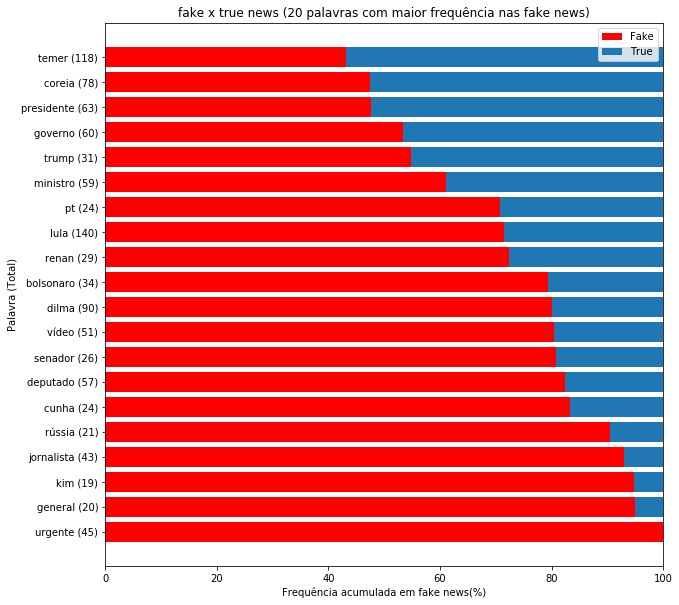

In [89]:
F_pd = dfC_F.toPandas()
F_pd['Frequência_F (%)']=round(F_pd['Frequência_F (%)'],0)
F_pd=F_pd[0:40]
print(F_pd)

fig, ax = plt.subplots(figsize=(10,10))

width=.8

x=F_pd['Palavra_F'][0:20]
yT=F_pd['Frequência_T'][0:20]
yF=F_pd['Frequência_F'][0:20]
yS=yT+yF
x=list(map(lambda n,y: n+" (" + str(y) + ")" ,x,yS ))
yT=round(100*yT/yS,2)
yF=round(100*yF/yS,2)

df=[x,yF,yT]
df=pd.DataFrame(df).T
df.columns=["Palavra_F","F(%)","T(%)"]
df=df.sort_values(by=["F(%)"],ascending=False)


x=df["Palavra_F"]
yT=df["T(%)"]
yF=df["F(%)"]
ax.barh(x, yF, width, label='Fake',color="red")
ax.barh(x, yT, width,left=yF ,label='True')

ax.set_ylabel('Palavra (Total)')
ax.set_xlabel('Frequência acumulada em fake news(%)')
ax.set_title('fake x true news (20 palavras com maior frequência nas fake news)')
ax.legend()

plt.show()

## True News

        Palavra_T  Frequência_T  Frequência_F  Diferença  Frequência_T(%)
0           temer            67            51         16             57.0
1          coreia            41            37          4             53.0
2            lula            40           100        -60             29.0
3            veja            39             9         30             81.0
4   retrospectiva            35             0         35            100.0
5      presidente            33            30          3             52.0
6              pf            30            17         13             64.0
7            juiz            29            12         17             71.0
8         governo            28            32         -4             47.0
9         polícia            26            12         14             68.0
10         defesa            26             9         17             74.0
11           moro            25            15         10             62.0
12       ministro            23       

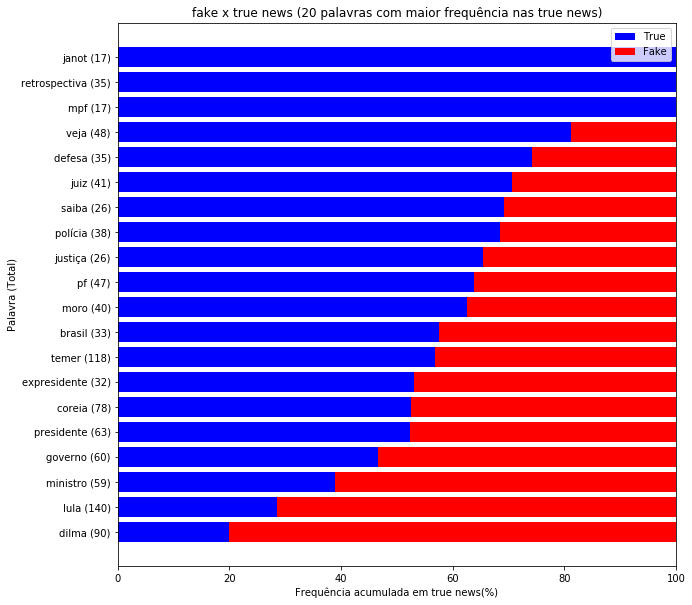

In [90]:
T_pd = dfC_T.toPandas()
T_pd['Frequência_T(%)']=round(T_pd['Frequência_T(%)'],0)
T_pd=T_pd[0:40]
print(T_pd)

#######
fig, ax = plt.subplots(figsize=(10,10))

width=.8

x=T_pd['Palavra_T'][0:20]
yT=T_pd['Frequência_T'][0:20]
yF=T_pd['Frequência_F'][0:20]
yS=yT+yF
x=list(map(lambda n,y: n+" (" + str(y) + ")" ,x,yS ))
yT=round(100*yT/yS,2)
yF=round(100*yF/yS,2)

df=[x,yT,yF]
df=pd.DataFrame(df).T
df.columns=["Palavra_T","T(%)","F(%)"]
df=df.sort_values(by=["T(%)"],ascending=True)


x=df["Palavra_T"]
yT=df["T(%)"]
yF=df["F(%)"]
ax.barh(x, yT, width, label='True',color="blue")
ax.barh(x, yF, width,left=yT ,label='Fake',color="red")

ax.set_ylabel('Palavra (Total)')
ax.set_xlabel('Frequência acumulada em true news(%)')
ax.set_title('fake x true news (20 palavras com maior frequência nas true news)')
ax.legend()

plt.show()